# Re-entrant Corner Problem

Here we will consider the classic _re-entrant corner_ problem,
\begin{align*}
-\Delta u &= f, && \text{in } \Omega, \\
u &= g, && \text{on } \partial\Omega,
\end{align*}
where the domain is given using polar coordinates,
\begin{gather*}
\Omega = \{ (r,\varphi)\colon r\in(0,1), \varphi\in(0,\Phi) \}~.
\end{gather*}
For the boundary condition $g$, we set it to the trace of the function $u$, given by
\begin{gather*}
u(r,\varphi) = r^{\frac{\pi}{\Phi}} \sin\big(\frac{\pi}{\Phi} \varphi \big)
\end{gather*}

In [1]:
import matplotlib
matplotlib.rc( 'image', cmap='jet' )
import math
import numpy
import matplotlib.pyplot as pyplot
from dune.fem.plotting import plotPointData as plot
import dune.grid as grid
import dune.fem as fem
from dune.fem.view import adaptiveLeafGridView as adaptiveGridView
from dune.fem.space import lagrange as solutionSpace
from dune.alugrid import aluConformGrid as leafGridView
from ufl import *
from dune.ufl import DirichletBC


# set the angle for the corner (0<angle<=360)
cornerAngle = 320.

# use a second order space
order = 2

We first define the domain and set up the grid and space.
We need this twice - once for a computation on a globally refined grid
and once for an adaptive one so we put the setup into a function:

We first define the grid for this domain (vertices are the origin and 4
equally spaced points on the unit sphere starting with (1,0) and
ending at (cos(cornerAngle), sin(cornerAngle))

Next we define the model together with the exact solution.

In [2]:
def setup():
    vertices = numpy.zeros((8, 2))
    vertices[0] = [0, 0]
    for i in range(0, 7):
        vertices[i+1] = [math.cos(cornerAngle/6*math.pi/180*i),
                         math.sin(cornerAngle/6*math.pi/180*i)]
    triangles = numpy.array([[2,1,0], [0,3,2], [4,3,0],
                             [0,5,4], [6,5,0], [0,7,6]])
    domain = {"vertices": vertices, "simplices": triangles}
    gridView = adaptiveGridView( leafGridView(domain) )
    gridView.hierarchicalGrid.globalRefine(2)
    space = solutionSpace(gridView, order=order, storage="istl")

    from dune.fem.scheme import galerkin as solutionScheme
    u = TrialFunction(space)
    v = TestFunction(space)
    x = SpatialCoordinate(space.cell())

    # exact solution for this angle
    Phi = cornerAngle / 180 * pi
    phi = atan_2(x[1], x[0]) + conditional(x[1] < 0, 2*pi, 0)
    exact = dot(x, x)**(pi/2/Phi) * sin(pi/Phi * phi)
    a = dot(grad(u), grad(v)) * dx

    # set up the scheme
    laplace = solutionScheme([a==0, DirichletBC(space, exact, 1)], solver="cg",
                parameters={"newton.linear.preconditioning.method":"amg-ilu"})
    uh = space.interpolate([0], name="solution")
    return uh, exact, laplace

We will start with computing the $H^1$ error on a sequence of globally
refined grids

Note that by using `fem.globalRefine` instead of
`hierarchicalGrid.globalRefine` we can prolongate discrete functions
to the next level. The second argument can also be a list/tuple
of discrete functions to prolong. With this approach we optain a good
initial guess for solving the problem on the refined grid.

In [3]:
uh, exact, laplace = setup()
h1error = dot(grad(uh - exact), grad(uh - exact))
errorGlobal = []
dofsGlobal  = []
for count in range(10):
    laplace.solve(target=uh)
    error = math.sqrt(fem.function.integrate(uh.space.grid, h1error, 5))
    errorGlobal += [error]
    dofsGlobal  += [uh.space.size]
    print(count, ": size=", uh.space.grid.size(0), "error=", error)
    fem.globalRefine(1,uh)

0 : size= 24 error= 0.16712344009166388


1 : size= 48 error= 0.14711976142612884


2 : size= 96 error= 0.11241382403045251


3 : size= 192 error= 0.09913242160785005


4 : size= 384 error= 0.07589928535968841


5 : size= 768 error= 0.06696392694258921


6 : size= 1536 error= 0.051322077571877164


7 : size= 3072 error= 0.04529205625699549


8 : size= 6144 error= 0.03472907035106892


9 : size= 12288 error= 0.03065256551369635


Theory tells us that
\begin{align*}
\int_\Omega |\nabla(u-u_h)|^2 \leq \sum_K \eta_K,
\end{align*}
where on each element $K$ of the grid the local estimator is given by
\begin{align*}
\eta_K = h_K^2 \int_K |\triangle u_h|^2 +
  \frac{1}{2}\sum_{S\subset \partial K} h_S \int_S [\nabla u_h]^2.
\end{align*}
Here $[\cdot]$ is the jump in normal direction over the edges of the grid.

We compute the elementwise indicator by defining a bilinear form
\begin{align*}
\eta(u,v) = \int_\Omega h^2 |\triangle u_h|^2 v +
    \int_{I_h} h_S [\nabla u_h]^2 \{v\},
\end{align*}
where $\{\cdot\}$ is the average over the cell edges and $[\cdot]$
the jump. With $h$ and $h_S$ we denote local grid spacings and with
$I_h$ the set of all facets in the grid.
This bilinear form can be easily written in UFL and by using it to
define a discrete operator $L$ from the second order Lagrange space into a space containing piecewise constant functions
we have $L[u_h]|_{K} = \eta_K$.

In [4]:
uh, exact, laplace = setup()

from dune.fem.space import finiteVolume as estimatorSpace
from dune.fem.operator import galerkin as estimatorOp

fvspace = estimatorSpace(uh.space.grid)
estimate = fvspace.interpolate([0], name="estimate")

u = TrialFunction(uh.space.as_ufl())
v = TestFunction(fvspace)
hT = MaxCellEdgeLength(fvspace.cell())
he = MaxFacetEdgeLength(fvspace.cell())('+')
n = FacetNormal(fvspace.cell())
estimator_ufl = hT**2 * (div(grad(u)))**2 * v * dx +        he * inner(jump(grad(u)), n('+'))**2 * avg(v) * dS
estimator = estimatorOp(estimator_ufl)
tolerance = 0.05

Let us solve over a loop (solve,estimate,mark) and plot the solutions side by side.

2 : size= 34 estimate= 0.8690256805073884 error= 0.11221970888081521


5 : size= 48 estimate= 0.6508740928913376 error= 0.07598644417123845


8 : size= 70 estimate= 0.4841803529940786 error= 0.05176032793637977


11 : size= 100 estimate= 0.3449992651635165 error= 0.039351119134677384


14 : size= 162 estimate= 0.21512693648774653 error= 0.02346465758053776


17 : size= 222 estimate= 0.15969465946679126 error= 0.017590149059560856


20 : size= 358 estimate= 0.09547041500029754 error= 0.010689245705173966


23 : size= 650 estimate= 0.052818069557873056 error= 0.006112308575269022


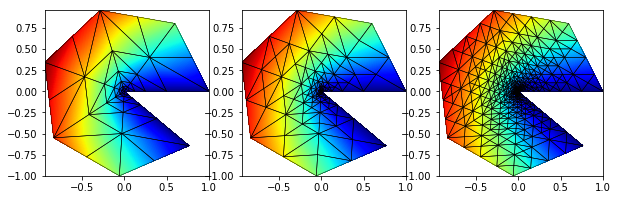

In [5]:
h1error = dot(grad(uh - exact), grad(uh - exact))
fig = pyplot.figure(figsize=(10,10))
count = 0
errorVector    = []
estimateVector = []
dofs           = []
while True:
    laplace.solve(target=uh)
    if count%9 == 8:
        plot(uh, figure=(fig, 131+count//9), colorbar=False)
    error = math.sqrt(fem.function.integrate(uh.space.grid, h1error, 5))
    estimator(uh, estimate)
    eta = math.sqrt( sum(estimate.dofVector) )
    dofs           += [uh.space.size]
    errorVector    += [error]
    estimateVector += [eta]
    if count%3 == 2:
        print(count, ": size=", uh.space.grid.size(0), "estimate=", eta, "error=", error)
    if eta < tolerance:
        break
    marked = fem.doerflerMark(estimate,0.6,layered=0.1)
    fem.adapt(uh) # can also be a list or tuple of function to prolong/restrict
    fem.loadBalance(uh)
    count += 1
plot(uh, figure=(fig, 131+2), colorbar=False)
pyplot.show()
pyplot.close('all')

Let's have a look at the center of the domain:

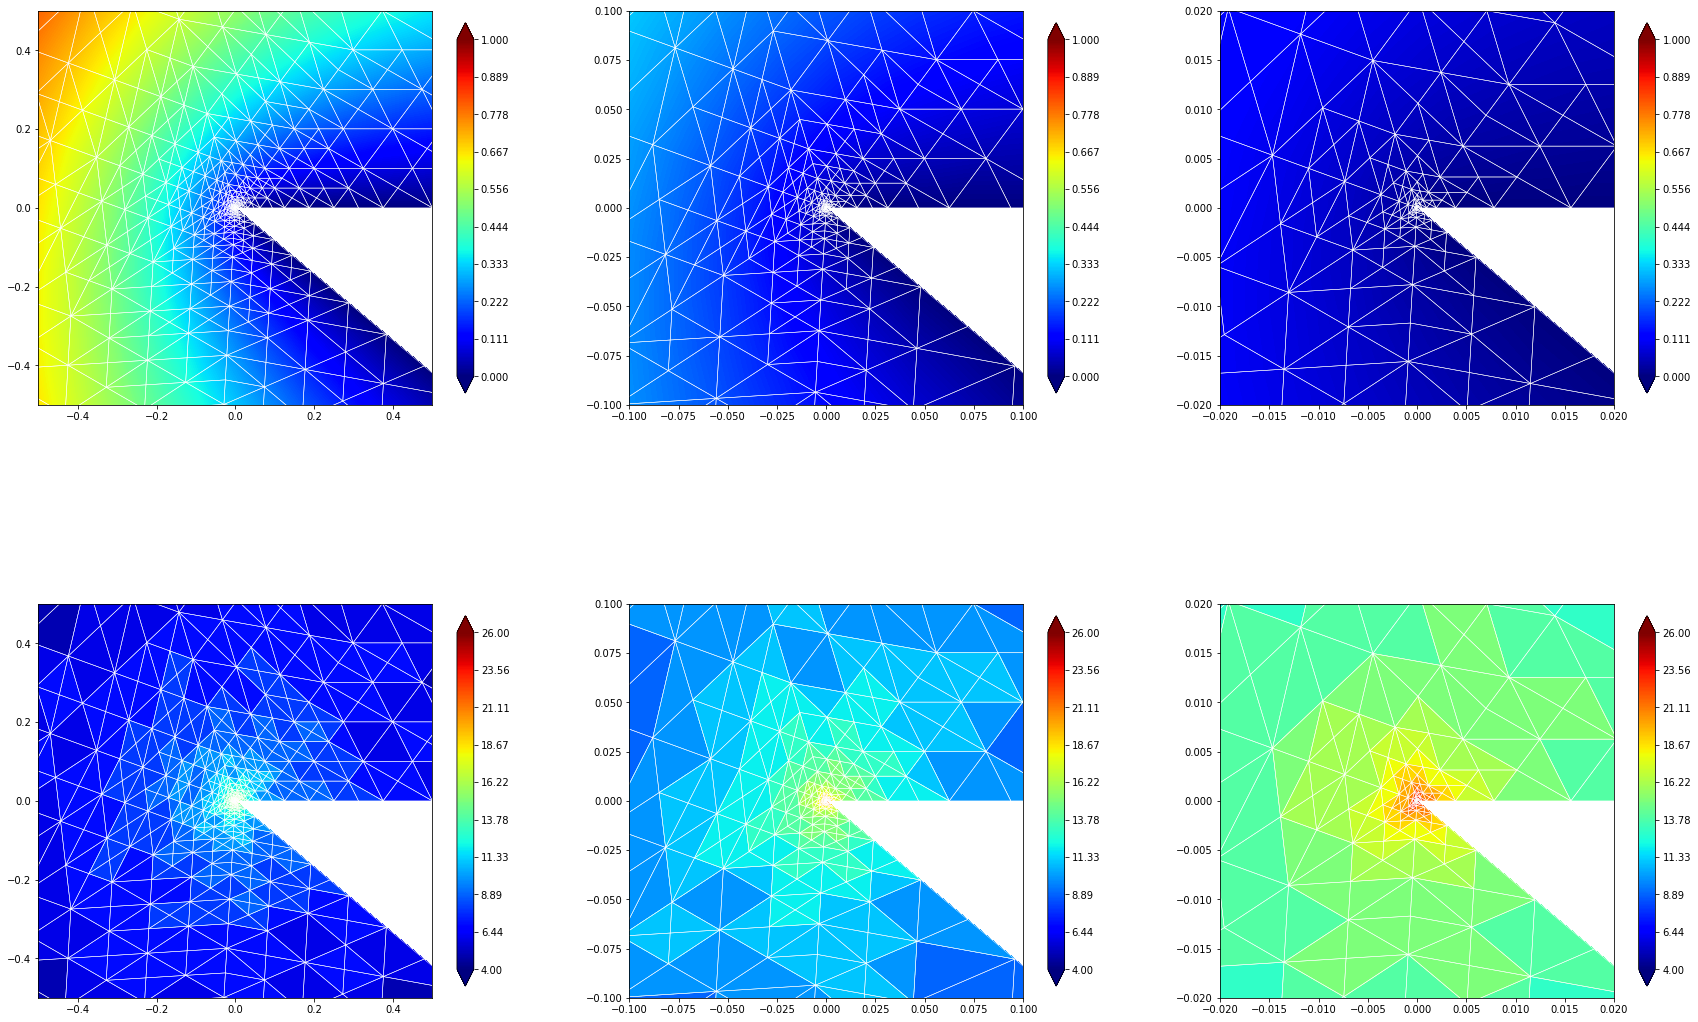

In [6]:
fig = pyplot.figure(figsize=(30,20))
plot(uh, figure=(fig, 231), xlim=(-0.5, 0.5), ylim=(-0.5, 0.5),
        gridLines="white", colorbar={"shrink": 0.75})
plot(uh, figure=(fig, 232), xlim=(-0.1, 0.1), ylim=(-0.1, 0.1),
        gridLines="white", colorbar={"shrink": 0.75})
plot(uh, figure=(fig, 233), xlim=(-0.02, 0.02), ylim=(-0.02, 0.02),
        gridLines="white", colorbar={"shrink": 0.75})

from dune.fem.function import levelFunction
levels = levelFunction(uh.space.grid)
plot(levels, figure=(fig, 234), xlim=(-0.5, 0.5), ylim=(-0.5, 0.5),
        gridLines="white", colorbar={"shrink": 0.75})
plot(levels, figure=(fig, 235), xlim=(-0.1, 0.1), ylim=(-0.1, 0.1),
        gridLines="white", colorbar={"shrink": 0.75})
plot(levels, figure=(fig, 236), xlim=(-0.02, 0.02), ylim=(-0.02, 0.02),
        gridLines="white", colorbar={"shrink": 0.75})
pyplot.show()
pyplot.close('all')

Finally, let us compare the globally refined solution and the adaptive
one plotting number of degrees of freedom versus the error and the
estimator

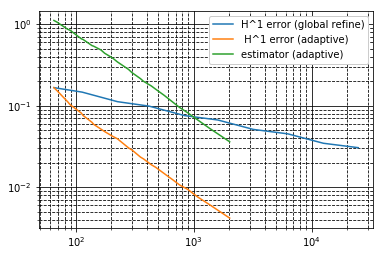

In [7]:
pyplot.loglog(dofsGlobal,errorGlobal,label="H^1 error (global refine)")
pyplot.loglog(dofs,errorVector,label=" H^1 error (adaptive)")
pyplot.loglog(dofs,estimateVector,label="estimator (adaptive)")
pyplot.grid(b=True, which='major', color='black', linestyle='-')
pyplot.grid(b=True, which='minor', color='black', linestyle='--')
pyplot.legend(frameon=True,facecolor="white",framealpha=1)
pyplot.show()